# Importing Library

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import sys

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

%matplotlib inline

In [2]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Data dictionary

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

In [3]:
# Looking at statistics of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df.drop_duplicates(inplace=True)
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


In [5]:
# Converting categorical into boolean using get_dummies 
# Getting the predicted values in terms of 0 and 1
Y = (df['y'] == 'yes')*1
Y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41176, dtype: int32

In [6]:
# Get X
X = df.drop("y", axis=1)
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6


## Exploratory Data Analysis

Will perform some Exploratory Data Analysis to see how different features are distribute in the dataset.

1.1 Visaulizing how age is distributed in the dataset

<Axes: xlabel='age', ylabel='Density'>

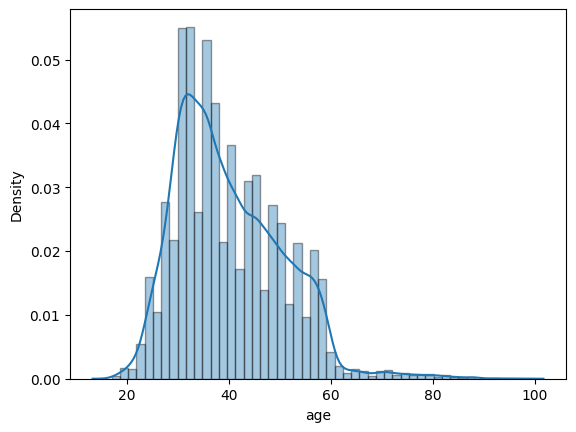

In [7]:
sns.distplot(df['age'], hist=True, hist_kws={'edgecolor':'black'})

1.2 Visualizing how Maritial Status and Education is distributed in the dataset.



[Text(0, 0, 'basic.4y'),
 Text(1, 0, 'high.school'),
 Text(2, 0, 'basic.6y'),
 Text(3, 0, 'basic.9y'),
 Text(4, 0, 'professional.course'),
 Text(5, 0, 'unknown'),
 Text(6, 0, 'university.degree'),
 Text(7, 0, 'illiterate')]

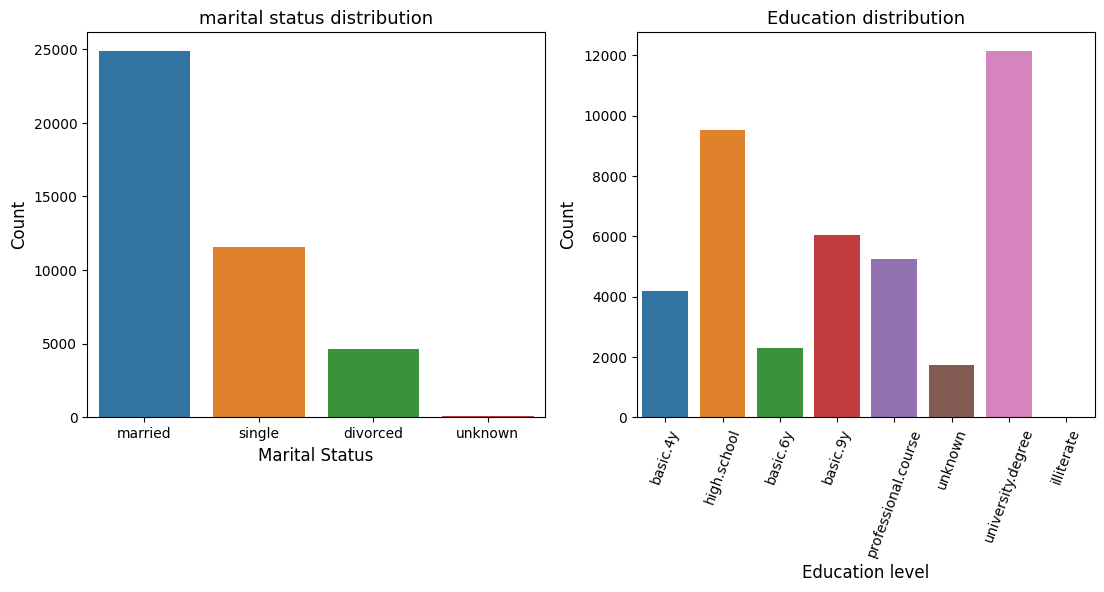

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

# First plot for marital status
sns.countplot(x = "marital", data = df, ax = ax1)
ax1.set_title("marital status distribution", fontsize = 13)
ax1.set_xlabel("Marital Status", fontsize = 12)
ax1.set_ylabel("Count", fontsize = 12)

# Second plot for Education distribution
sns.countplot(x = "education", data = df, ax = ax2)
ax2.set_title("Education distribution", fontsize = 13)
ax2.set_xlabel("Education level", fontsize = 12)
ax2.set_ylabel("Count", fontsize = 12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 70)

1.3 Visualizing how Jobs are distribution

Text(0.5, 1.0, 'Job Count Distribution')

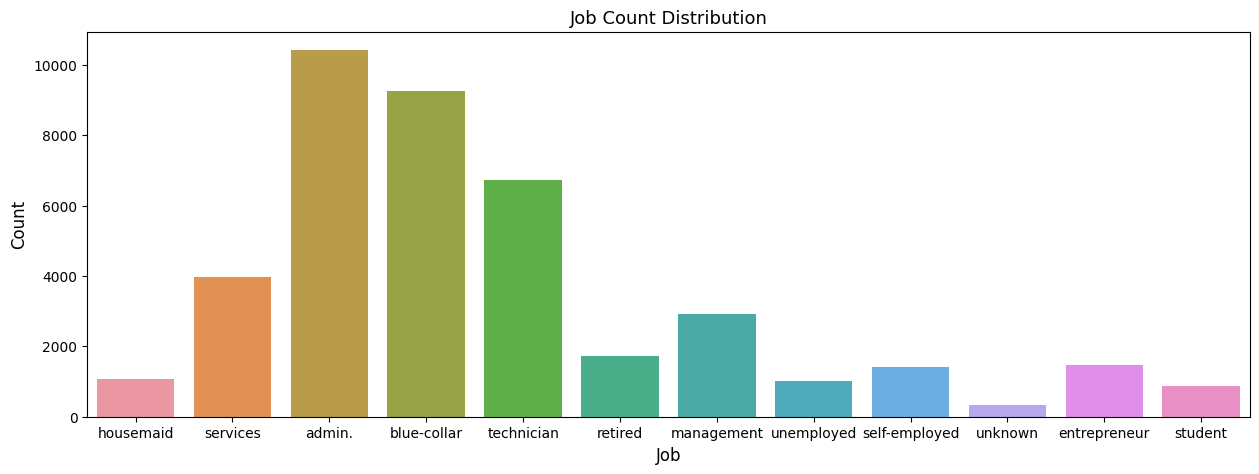

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
sns.countplot(x = "job", data = df)
ax.set_xlabel('Job', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
ax.set_title("Job Count Distribution", fontsize = 13)

1.4 Housing and Loan Distribution

Visualizing how: 

1. Housing Loans are distributed. 
2. Personal Loans are distributed.

Text(0, 0.5, 'Count')

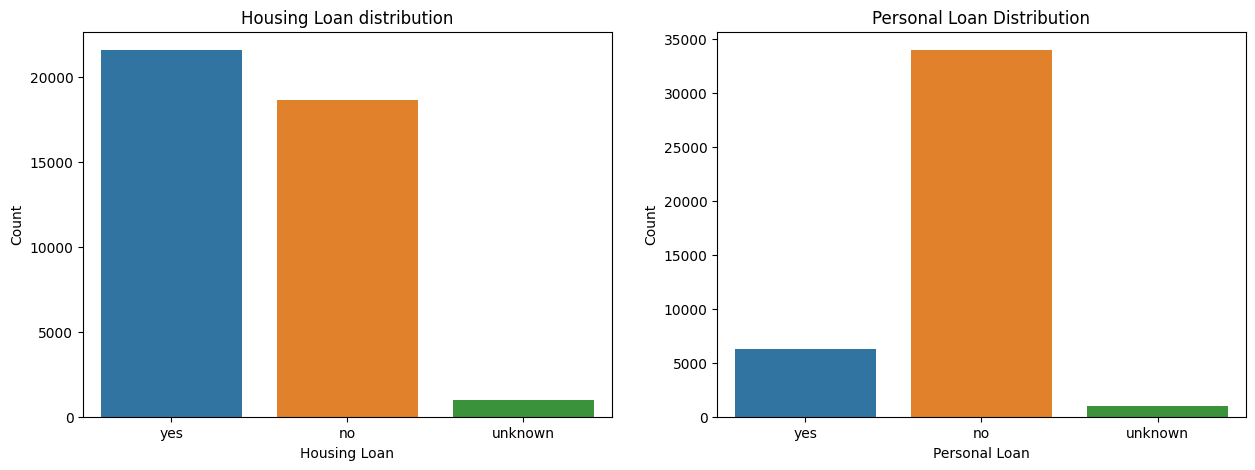

In [10]:
# Housing loan data distribution
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
sns.countplot(x = "housing", data = df, ax = ax1, order = ['yes', 'no', 'unknown'])
ax1.set_title("Housing Loan distribution")
ax1.set_xlabel("Housing Loan")
ax1.set_ylabel("Count")

# Personal loan data distribution
sns.countplot(x = "loan", data = df, ax = ax2, order = ['yes', 'no', 'unknown'])
ax2.set_title("Personal Loan Distribution")
ax2.set_xlabel("Personal Loan")
ax2.set_ylabel("Count")

Getting total count for: 

1. Credit Defaulters 
2. People with Housing loan 
3. People with Personal loan

*Credit Defaulter*

In [11]:
print("Number of people with credit default: ", df[df['default'] == 'yes']['default'].count())
print("Number of people with no credit default: ", df[df['default'] == 'no']['default'].count())
print("Number of people who's credit default is unknown: ", df[df['default'] == 'unknown']['default'].count())

Number of people with credit default:  3
Number of people with no credit default:  32577
Number of people who's credit default is unknown:  8596


*Housing Loan*

In [12]:
print("Number of people with Housing loan: ", df[df['housing'] == 'yes']['housing'].count())
print("Number of people with no Housing loan: ", df[df['housing'] == 'no']['housing'].count())
print("Number of people who's Housing loan is unknown: ", df[df['housing'] == 'unknown']['housing'].count())

Number of people with Housing loan:  21571
Number of people with no Housing loan:  18615
Number of people who's Housing loan is unknown:  990


*Personal Loan*

In [13]:
print("Number of people with Personal loan: ", df[df['loan'] == 'yes']['loan'].count())
print("Number of people with no Personal loan: ", df[df['loan'] == 'no']['loan'].count())
print("Number of people who's Personal loan is unknown: ", df[df['loan'] == 'unknown']['loan'].count())

Number of people with Personal loan:  6248
Number of people with no Personal loan:  33938
Number of people who's Personal loan is unknown:  990


1.4 Visualisation related to "Last Contact of the Current Campaign" 

<i> Visualisation related to Duration </i>

Plotting duration using boxplot makes it difficult to obtain some important values like average of distribution and so I am plotting histogram on the side to see how its distributed and check for mean value (If its possible). 

Text(0.5, 1.0, 'Call Duration vs Count')

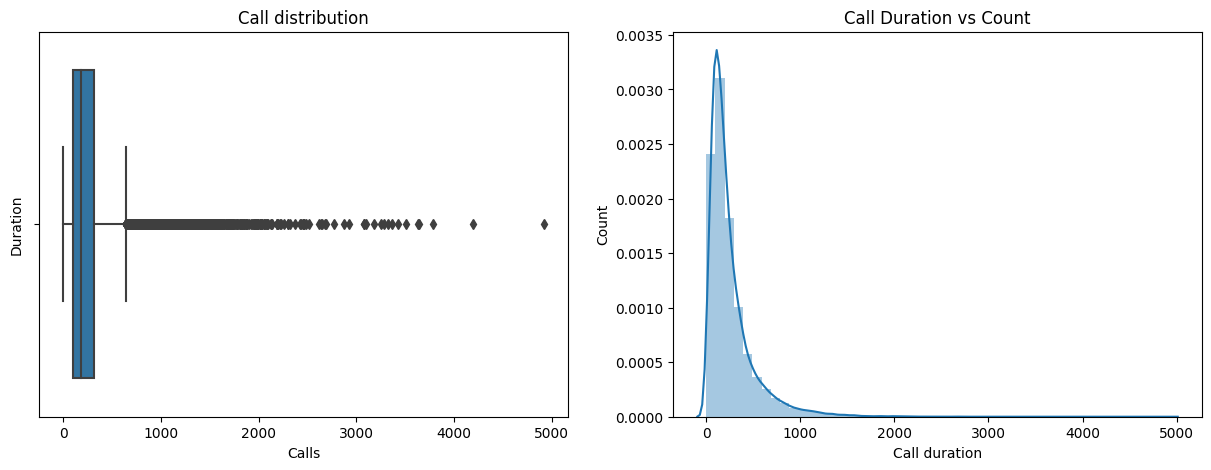

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

sns.boxplot(x = "duration", data = df, orient = 'v', ax = ax1)
ax1.set_xlabel("Calls")
ax1.set_ylabel("Duration")
ax1.set_title("Call distribution")

sns.distplot(df['duration'], ax = ax2)
ax2.set_xlabel("Call duration")
ax2.set_ylabel("Count")
ax2.set_title("Call Duration vs Count")

Getting all the Mean, Standard Diveation, Minimum and Maximum values for duration  

In [15]:
min_duration = df['duration'].min()
max_duration = df['duration'].max()
median_duration = df['duration'].mean()
standard_dev_duration = df["duration"].std()

print("Min call duration: ", min_duration)
print("Max call duration: ", max_duration)
print("Median call duration: ", round(median_duration, 2))
print("Standard diveation in call duration: ", round(standard_dev_duration, 2))

Min call duration:  0
Max call duration:  4918
Median call duration:  258.32
Standard diveation in call duration:  259.31


We can see from the box plot that most call duration is around the mean so finding the interquartile range will help us in understanding how long the call might last

In [16]:
first_quartile = df['duration'].quantile(q = 0.25)
second_quartile = df['duration'].quantile(q = 0.50)
third_quartile = df['duration'].quantile(q = 0.75)
fourth_quartile = df['duration'].quantile(q = 1)
IRQ = third_quartile - second_quartile

print("Second Quartile: ", second_quartile)
print("Third Quartile: ", third_quartile)
print("Inter quartile range(range within which most data is present): ",IRQ)

Second Quartile:  180.0
Third Quartile:  319.0
Inter quartile range(range within which most data is present):  139.0


 <i> Visualisation related to "Contact, Month" </i>

Text(0.5, 1.0, 'Count of Contact Methods')

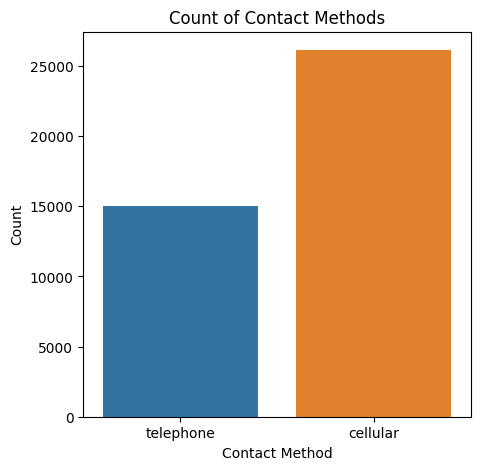

In [18]:
fig, (ax1) = plt.subplots(nrows = 1, ncols =1 , figsize = (5, 5))

sns.countplot(x = 'contact', data = df, ax = ax1)
ax1.set_xlabel("Contact Method")
ax1.set_ylabel("Count")
ax1.set_title("Count of Contact Methods")

# day_of_week.value_counts()
# sns.countplot(X['day_of_week'], ax = ax2)
# ax2.set_xlabel("Days of the week")
# ax2.set_ylabel("Count")
# ax2.set_title("Count of Calls made on Days of the week")

Text(0.5, 1.0, 'Count of contacts made in each month')

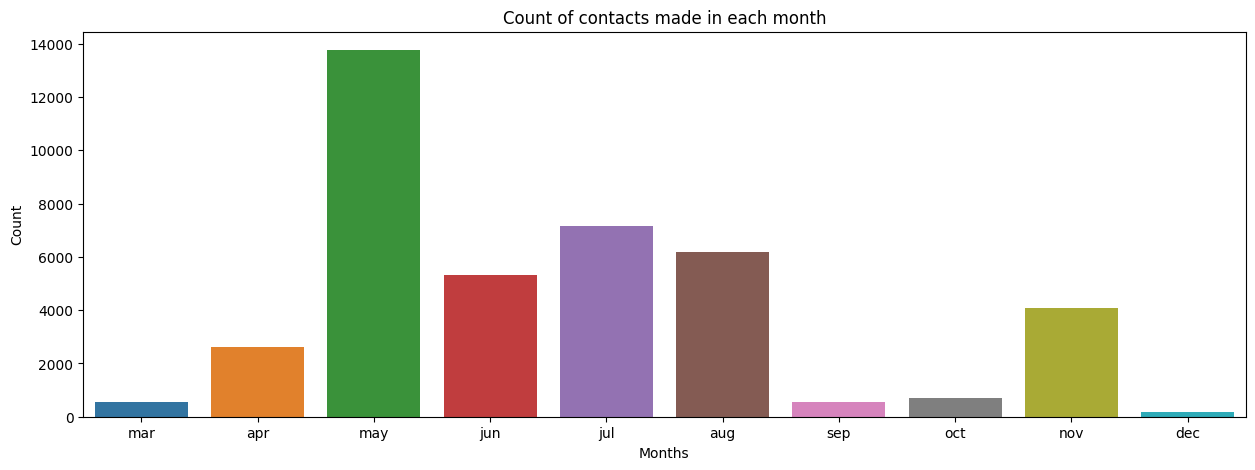

In [19]:
# For Months
fig, ax = plt.subplots(figsize = (15, 5))
sns.countplot(x = 'month', data = df, order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
ax.set_xlabel("Months")
ax.set_ylabel("Count")
ax.set_title("Count of contacts made in each month")

*Checking if there exists a relation between  Duration of call and Jobs*

Text(0.5, 1.0, 'log(Duration) vs Jobs')

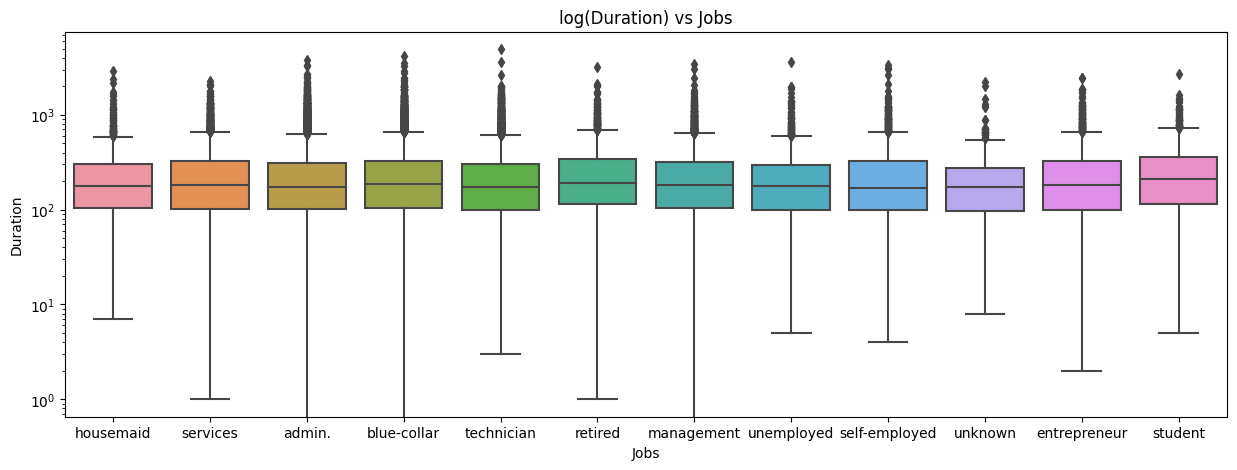

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "job", y = "duration", data = df, orient = 'v')
ax.set_xlabel("Jobs")
ax.set_ylabel("Duration")
ax.set_yscale("log")
ax.set_title("log(Duration) vs Jobs")

*Checking if there is a relation between average duration of call and eduacation *

Text(0.5, 1.0, 'log(Duration) vs Education')

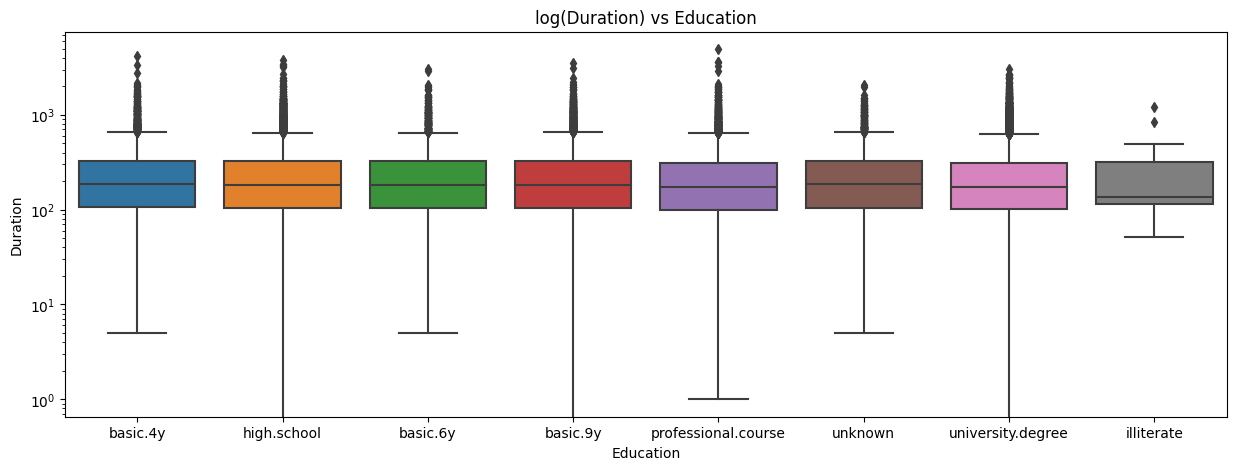

In [21]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "education", y = "duration", data = df, orient = 'v')
ax.set_xlabel("Education")
ax.set_ylabel("Duration")
ax.set_yscale("log")
ax.set_title("log(Duration) vs Education")

BANK CLIENTS CONCLUSION

The ages dont mean to much, has a medium dispersion and dont make sense relate with other variables will not tell any insight

Jobs, Marital and Education i think the best analisys is just the count of each variable, if we related with the other ones its is not conclusive, all this kind of variables has yes, unknown and no for loan, default and housing.

Default, loan and housing, its just to see the distribution of people.

### Categorical Treatment
Different categorial features and there values in the dataset are:

In [22]:
print("Jobs: \n", df["job"].unique(),'\n')
print("Marital Status: \n", df['marital'].unique(),'\n')
print("Education: \n", df['education'].unique(),'\n')
print("Default on Credit: \n", df['default'].unique(),'\n')
print("Housing loan: \n", df['housing'].unique(),'\n')
print("Loan default: \n", df['loan'].unique(),'\n')
print("Contact type: \n", df['contact'].unique(),'\n')
print("Months: \n", df['month'].unique(),'\n')
print("day_of_week: \n", df['day_of_week'].unique(),'\n')
print("Poutcome: \n",df["poutcome"].unique(),'\n')

Jobs: 
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

Marital Status: 
 ['married' 'single' 'divorced' 'unknown'] 

Education: 
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

Default on Credit: 
 ['no' 'unknown' 'yes'] 

Housing loan: 
 ['no' 'yes' 'unknown'] 

Loan default: 
 ['no' 'yes' 'unknown'] 

Contact type: 
 ['telephone' 'cellular'] 

Months: 
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

day_of_week: 
 ['mon' 'tue' 'wed' 'thu' 'fri'] 

Poutcome: 
 ['nonexistent' 'failure' 'success'] 



### Creating label encoders to treat all categorical variables

In [23]:
labelencoder_X = LabelEncoder()

In [24]:
X["job"] = labelencoder_X.fit_transform(df["job"])
X["marital"] = labelencoder_X.fit_transform(df["marital"])
X["education"] = labelencoder_X.fit_transform(df["education"])
X["default"] = labelencoder_X.fit_transform(df["default"])
X["housing"] = labelencoder_X.fit_transform(df["housing"])
X["loan"] = labelencoder_X.fit_transform(df["loan"])
X["contact"] = labelencoder_X.fit_transform(df["contact"])
X["month"] = labelencoder_X.fit_transform(df["month"])
X["day_of_week"] = labelencoder_X.fit_transform(df["day_of_week"])
X["poutcome"] = labelencoder_X.fit_transform(df["poutcome"])

X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,3,1,0,0,0,0,1,6,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
1,57,7,1,3,1,0,0,1,6,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
2,37,7,1,3,0,2,0,1,6,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
3,40,0,1,1,0,0,0,1,6,1,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
4,56,7,1,3,0,0,2,1,6,1,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0


### Splitting the data

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=.2, random_state=42)

In [26]:
print('X_train:',x_train.shape)
print('y_train:',y_train.shape)
print('X_test:',x_test.shape)
print('y_test:',y_test.shape)

X_train: (32940, 20)
y_train: (32940,)
X_test: (8236, 20)
y_test: (8236,)


#### Convert Pandas dataframe, first to numpy and then to Torch Tensors

In [27]:
# X_train = tch.from_numpy(X_train.values)
# x_test = torch.from_numpy(x_test.values)
# Y_train = tch.from_numpy(Y_train.values).reshape(-1,1)
# y_test = tch.from_numpy(y_test.values).reshape(-1,1)

## Model Building

In [28]:
class Data(torch.utils.data.Dataset):
    def __init__(self,X,y):
        super().__init__()
        self.X = torch.from_numpy(X.values)
        self.y = torch.from_numpy(y.values)
        
    def __len__(self): 
        return len(self.X)
    
    def __getitem__(self,i): 
        return (self.X[i], self.y[i])

### Define the Neural Net

In [29]:
class Neural_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer = nn.Sequential(
            nn.Linear(20,128),
            nn.Tanh(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1),
        )
        
    def forward(self, X):
        return self.layer(X)

### Training parameters

In [30]:
NN = Neural_Network()

train_dataset = Data(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)

optimizer = torch.optim.SGD(NN.parameters(), lr=1e-4)

loss_func = nn.MSELoss()

epochs = 150

### The Training Loop 

In [31]:
for epoch in range(epochs):
    total_training_loss = 0
    for i, data in enumerate(train_loader,0):
        features,target = data
        features,target = features.float(),target.float()
        target = target.reshape(-1,1)
        
        optimizer.zero_grad()
        
        pred = NN.forward(features)

        loss = loss_func(pred, target)
        total_training_loss += loss.item()

        loss.backward() 
        optimizer.step()
    if epoch % 50 == 0:
        print(f'epoch: {epoch} - loss: {total_training_loss}')

epoch: 0 - loss: 29.420549035072327
epoch: 50 - loss: 19.3724032510072
epoch: 100 - loss: 18.65291717275977


### Make Predictions

In [32]:
preds = NN.forward(torch.from_numpy(x_test.values).float())
preds = preds.detach().numpy().reshape(-1,)
result = pd.DataFrame(
    {
        'Actual':y_test,
        'Prediction':np.round(preds).astype(int)
    }
)

result.head(10)

,Actual,Prediction
8490,0,0
40844,1,1
35681,0,0
35994,0,0
21961,0,0
11522,0,0
35058,0,0
31093,0,0
32880,0,0
22655,0,0


In [33]:
from sklearn.metrics import r2_score

r2_score(y_test,preds)

0.2726152394390533

Training Metrics :